In [18]:
#%pip install torch torchvision torchaudio
#%pip install scipy

import pandas as pd
from transformers import pipeline
import torch


In [52]:
lazy_df = pl.scan_csv(r"C:\Users\Mert\OneDrive\Desktop\Courses\Financial Big Data\data\nasdaq_exteral_data.csv")

NameError: name 'pl' is not defined

In [53]:
lazy_df.columns

NameError: name 'lazy_df' is not defined

In [54]:
filtered_df = (
    lazy_df
    .select(["Date", "Stock_symbol", "Article_title"])  # Select specific columns
    .filter(pl.col("Article_title").is_not_null())  # Filter null values
    .filter(pl.col("Stock_symbol") == "AAPL")  # Filter Stock_symbol == AAPL 
    .with_columns(pl.col("Date").str.to_datetime("%Y-%m-%d %H:%M:%S UTC"))  # Convert Date to proper datetime format
)

NameError: name 'lazy_df' is not defined

In [55]:
apple_df = (pd.DataFrame(filtered_df.collect())
            .dropna()
            .drop_duplicates()
            .rename({0 : "Date",1 : "Stock_Symbol",2 : "Article_title"}, axis = 1)
            )

NameError: name 'filtered_df' is not defined

In [56]:
apple_df.to_csv("../data/apple_news.csv")

NameError: name 'apple_df' is not defined

### 0. Cleaning our data

Here I needed to properly clean the dataset we have before processing it

In [19]:
#First choose what dataset we want to clean.
#I want us to first work with Apple news dataset but we could work with any dataset (just replace the path)
df_to_clean = pd.read_csv("../data/apple_news.csv")
df_to_clean.head()

,Unnamed: 0,Date,Stock_Symbol,Article_title
0,0,2023-12-16 22:00:00,AAPL,My 6 Largest Portfolio Holdings Heading Into 2...
1,1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...
2,2,2023-12-16 21:00:00,AAPL,"Company News for Dec 19, 2023"
3,3,2023-12-16 21:00:00,AAPL,NVIDIA (NVDA) Up 243% YTD: Will It Carry Momen...
4,4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,..."



TODO :
-Remove unnamed index column
-Parse the Date column to datetime format.
-Incorporate sentiment analysis with Dis roberta to generate sentiment scores

In [20]:
# Drop the column 'Unnamed: 0' from the DataFrame 'df_to_clean' becuase it is not needed for analysis.
df_to_clean = df_to_clean.drop(columns=['Unnamed: 0'])
# Convert the 'Date' column to a datetime object
df_to_clean['Date'] = pd.to_datetime(df_to_clean['Date'])
#filter the DataFrame 'df_filtered' to only include rows where the 'Article_title' column contains the word 'Apple' or 'AAPL'.
df_filtered = df_to_clean[df_to_clean['Article_title'].str.contains(r'\b(Apple|AAPL)\b', case=False, na=False)]

/var/folders/00/1h1mgh1j2gb16vq65twfjnjh0000gn/T/ipykernel_16630/1277058383.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtered = df_to_clean[df_to_clean['Article_title'].str.contains(r'\b(Apple|AAPL)\b', case=False, na=False)]


In [21]:
#Finally, save the cleaned dataset
#If we work with another dataset, change the path
df_filtered.to_csv("../data/clean/apple_news_c.csv")
df_filtered.head()

,Date,Stock_Symbol,Article_title
1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...
4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,..."
6,2023-12-16 20:00:00,AAPL,AAPL Quantitative Stock Analysis
15,2023-12-16 04:00:00,AAPL,"After Hours Most Active for Dec 18, 2023 : PAC..."
16,2023-12-16 04:00:00,AAPL,"Technology Sector Update for 12/18/2023: PCT, ..."


### 1. News-data Preprocessing

#### Here we start our data processing work to convert get the sentiment

Assume that the dataset of the news is a constant flow of the news, then we try to construct a stochastic process on sentiment: use distrillroberta to generate sentiment(positive, neutral, negative) of the news headline and labelled the as (1, 0, -1) scores. Noted that the news are always released in two ways: one is that the news are released at midnight(or non-trading time) in batches, the others are released during trading time without batches(a flow-released news). For batch-released news, average the sentiment score.

THe formula for the stochastic process is be written as 

$$
I_t^s = \sum_{j} g(f(e_{jt}^{s})), 
g(x) = \begin{cases} 1, x = "Positive"\\
0, x = "Neutral"\\
-1, x = "Negative"\\
\end{cases},

f(x) = roBERTa(x),

$$

$f(x)$ is the pretrained sentiment classifier. $e_{jt}^{s}$ means the $j$-th embedding of the news headline at time $t$ for the stock $s$.

**Note**: time $t$ is not the natural time for trading, but it's proxy time interval between the new release, and it differs from stock to stock. Think of it as some sort of jump process.

In [22]:
cleaned_df = pd.read_csv("../data/clean/apple_news_c.csv")
cleaned_df.head(2)

,Unnamed: 0,Date,Stock_Symbol,Article_title
0,1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...
1,4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,..."


In [25]:
#%pip install torch
"""
This script performs sentiment analysis on financial news articles using the PRE-TRAINED model we selected from Hugging Face.
The sentiment analysis model used is 'distilroberta-finetuned-financial-news-sentiment-analysis', which is fine-tuned on the financial_phrasebank dataset.

Functions:
    classify_sentiment(article: str) -> int:
        Classifies the sentiment of a given article as positive, negative, or neutral.
        Returns 1 for positive sentiment, -1 for negative sentiment, and 0 for neutral sentiment.

The script reads a DataFrame 'cleaned_df' containing financial news articles, applies sentiment analysis to the 'Article_title' column,
and saves the resulting DataFrame with sentiment scores to a CSV file.

Usage:
    Ensure that the required libraries are installed and the input DataFrame 'cleaned_df' is loaded.
    Run the script to perform sentiment analysis and save the results to a CSV file.
"""
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# We will use distilRoberta-financial-sentiment a fine-tuned version of distilroberta-base on the financial_phrasebank dataset
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Let's apply the discussed sentiment analysis
def classify_sentiment(article):
    sentiment_result = sentiment_pipeline(article)[0]
    label = sentiment_result['label']
    if label == "positive":
        return 1
    elif label == "negative":
        return -1
    else:
        return 0

# Now we need to merge the sentiment scores to the dataset (AND AFTER MERGE INDEX)
cleaned_df['Sentiment'] = cleaned_df['Article_title'].apply(classify_sentiment)
cleaned_df.to_csv("../data/processed/processed_news_data_with_sent.csv", index=False)
print("Sentiment classification completed and saved to processed_news_data_with_sent.csv.")


Device set to use mps:0


KeyboardInterrupt: 

In [24]:
#Here we merge the sentiment scores to the dataset
merged_df = pd.read_csv("../data/processed/processed_news_data_with_sent.csv")
merged_df.head(2)

,Unnamed: 0,Date,Stock_Symbol,Article_title,Sentiment
0,1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...,0
1,4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,...",0


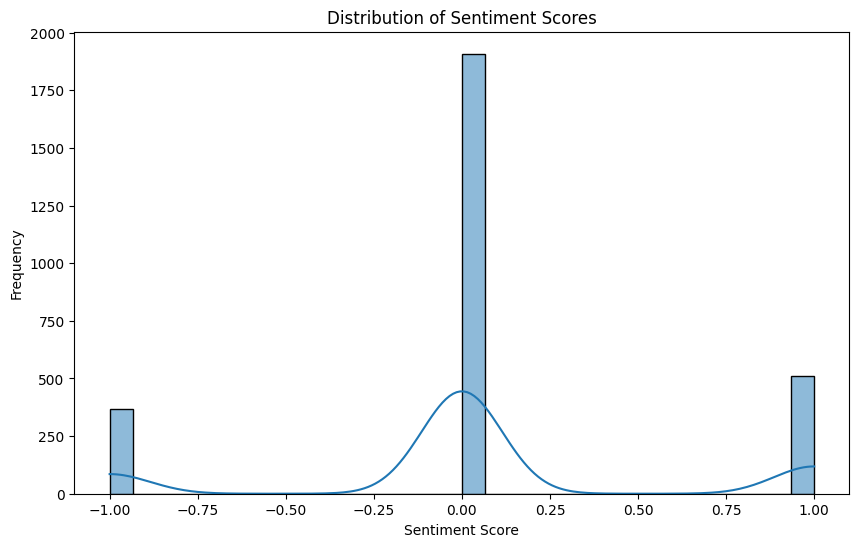

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### 2. Price-data preprocessing

#### Now that we have our data set with the sentiments, we want to link it to our stock price

Discretize the tick-by-tick data to align with the news-data, by identifying the return of the price. When the batch news are released in non-trading time, assume that the traders in the market will react to the news as soon as the trading time starts, for flow-released news, assume that the market participants will react as soon as the information of the news is understood. There will be two hyperparameter: the time-lag between the new release and the market reaction, and the fixed timeframe that uses to calculate the return of the price. Set the return of the stock as positive, stable and negative under a threshold and label it as (1,0,-1). Then we construct a stochastic process for stock return.

The formula for the stochastic process of the discretized return can be written as 

$$
R_{t}^{s} = h(\log \frac{P_{t + \delta}^{s}}{P_{t}^{s}}), 

h(x) = \begin{cases}1, x > \gamma \\ 0, \|x\| \leq \gamma \\ -1, x < -\gamma\end{cases},

\gamma, \delta > 0
$$

$P_{t}^{s}$ is the price of stock $s$ at time $t$, $\delta$ is the timeframe for the return calculation, $\gamma$ is the threshold of classifying the return.

#### 2.1 Cleaning the price dataset

In [44]:
returns_data = pd.read_csv("../data/quotes/apple_quotes.csv").drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

returns_data

,Date,Close
0,02/01/1981,0.154018
1,05/01/1981,0.150670
2,06/01/1981,0.143973
3,07/01/1981,0.137835
4,08/01/1981,0.135045
...,...,...
10603,23/01/2023,141.110001
10604,24/01/2023,142.529999
10605,25/01/2023,141.860001
10606,26/01/2023,143.960007


In [45]:
returns_data

,Date,Close
0,02/01/1981,0.154018
1,05/01/1981,0.150670
2,06/01/1981,0.143973
3,07/01/1981,0.137835
4,08/01/1981,0.135045
...,...,...
10603,23/01/2023,141.110001
10604,24/01/2023,142.529999
10605,25/01/2023,141.860001
10606,26/01/2023,143.960007


In [47]:

from scipy.optimize import minimize

# Calculate log returns
delta = 1
returns_data['Log_Return'] = np.log(returns_data['Close'] / returns_data['Close'].shift(delta))

# Define the Sharpe ratio calculation
def sharpe_ratio(returns):
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    return mean_return / std_return

# Define the classification function
def classify_return(x, gamma):
    if x > gamma:
        return 1  # Positive return
    elif x < -gamma:
        return -1  # Negative return
    else:
        return 0  # Stable return

# Define the objective function to minimize (negative Sharpe ratio)
def objective_function(gamma, returns):
    gamma = gamma[0]
    returns['Return_Label'] = returns['Log_Return'].apply(lambda x: classify_return(x, gamma))
    labeled_returns = returns[returns['Return_Label'] != 0]['Log_Return']
    return -sharpe_ratio(labeled_returns)

# Split the data into training and validation sets
train_data = returns_data[returns_data['Date'] < '2022-01-01']
validation_data = returns_data[returns_data['Date'] >= '2022-01-01']

# Initial gamma value
initial_gamma = 0.01

# Optimize gamma using the training data
result = minimize(objective_function, [initial_gamma], args=(train_data), bounds=[(0, 0.05)])
optimal_gamma = result.x[0]

# Validate the selected gamma on the validation dataset
validation_data['Return_Label'] = validation_data['Log_Return'].apply(lambda x: classify_return(x, optimal_gamma))
validation_labeled_returns = validation_data[validation_data['Return_Label'] != 0]['Log_Return']
validation_sharpe_ratio = sharpe_ratio(validation_labeled_returns)

print(f"Optimal Gamma: {optimal_gamma}")
print(f"Validation Sharpe Ratio: {validation_sharpe_ratio}")

# Apply the optimal gamma to the entire dataset
returns_data['Return_Label'] = returns_data['Log_Return'].apply(lambda x: classify_return(x, optimal_gamma))

# Save the processed dataset with optimal gamma
returns_data.to_csv("../data/processed/processed_apple_historical_data_with_optimal_gamma.csv", index=False)

Optimal Gamma: 0.01
Validation Sharpe Ratio: 0.023756934676650965


/var/folders/00/1h1mgh1j2gb16vq65twfjnjh0000gn/T/ipykernel_16630/543855018.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['Return_Label'] = returns['Log_Return'].apply(lambda x: classify_return(x, gamma))
/var/folders/00/1h1mgh1j2gb16vq65twfjnjh0000gn/T/ipykernel_16630/543855018.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['Return_Label'] = validation_data['Log_Return'].apply(lambda x: classify_return(x, optimal_gamma))


Now our quotes dataset includes the log return and looks like this :

In [48]:
returns_data

,Date,Close,Log_Return,Return_Label
0,02/01/1981,0.154018,NaN,0
1,05/01/1981,0.150670,-0.021977,-1
2,06/01/1981,0.143973,-0.045466,-1
3,07/01/1981,0.137835,-0.043568,-1
4,08/01/1981,0.135045,-0.020449,-1
...,...,...,...,...
10603,23/01/2023,141.110001,0.023229,1
10604,24/01/2023,142.529999,0.010013,1
10605,25/01/2023,141.860001,-0.004712,0
10606,26/01/2023,143.960007,0.014695,1


#### 2.2 Linking it to the news data
Now that we have a clean dataset to work on, let's merge our sentiment dataset with our returns dataset.

In [50]:
import pandas as pd

returns_data = pd.read_csv('../data/processed/processed_apple_historical_data_with_optimal_gamma.csv')
sentiment_data = pd.read_csv('../data/processed/processed_news_data_with_sent.csv').drop(U'Unnamed: 0', axis=1)
sentiment_data.tail(5)

,Date,Stock_Symbol,Article_title,Sentiment
2779,2020-03-10 00:00:00,AAPL,Peloton Shares Tick To Session Low As Hearing ...,-1
2780,2020-03-10 00:00:00,AAPL,"UBS Maintains Buy on Apple, Lowers Price Targe...",1
2781,2020-05-31 00:00:00,AAPL,Apple CEO Writes To Employees About George Flo...,0
2782,2020-05-28 00:00:00,AAPL,"Tredje AP-fonden Buys Microsoft Corp, Amazon.c...",0
2783,2020-05-28 00:00:00,AAPL,"The Zacks Analyst Blog Highlights: Apple, Exxo...",0


In [51]:
returns_data.tail(5)

,Date,Close,Log_Return,Return_Label
10603,23/01/2023,141.110001,0.023229,1
10604,24/01/2023,142.529999,0.010013,1
10605,25/01/2023,141.860001,-0.004712,0
10606,26/01/2023,143.960007,0.014695,1
10607,27/01/2023,145.929993,0.013591,1


/var/folders/00/1h1mgh1j2gb16vq65twfjnjh0000gn/T/ipykernel_16630/1738072137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sentiment_data['Date'] = pd.to_datetime(filtered_sentiment_data['Date'])


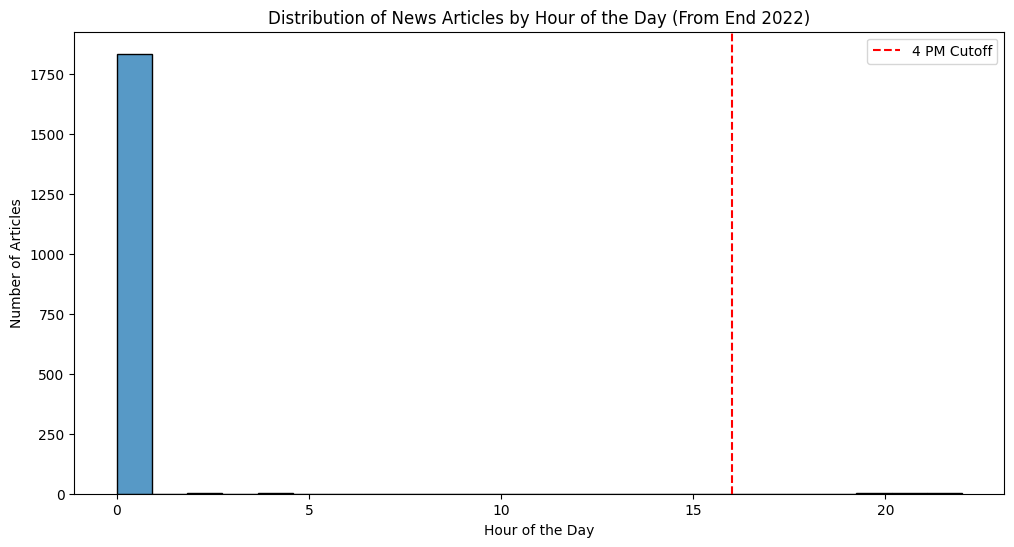

/var/folders/00/1h1mgh1j2gb16vq65twfjnjh0000gn/T/ipykernel_16630/1738072137.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sentiment_data['Trading_Date'] = filtered_sentiment_data['Date'].apply(


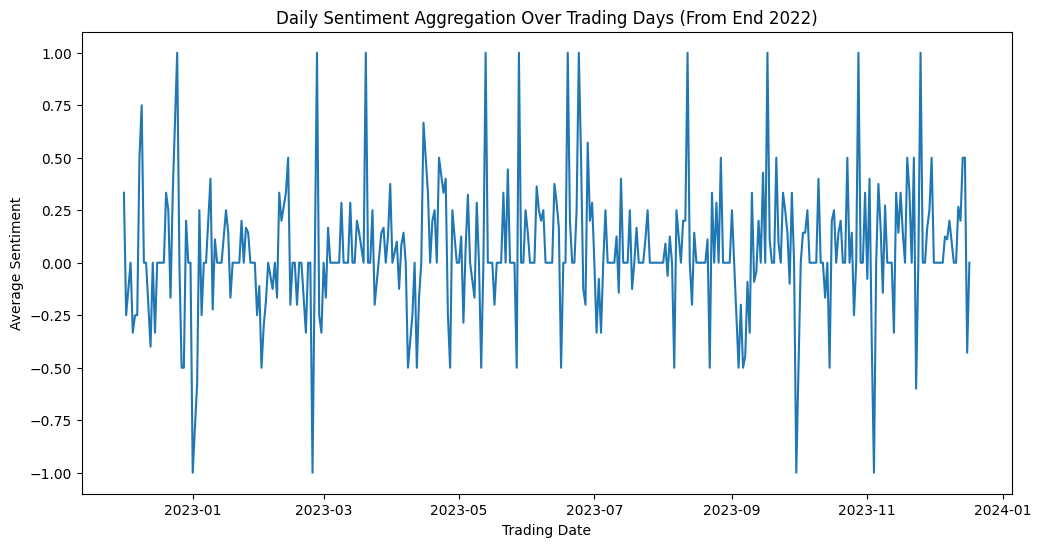

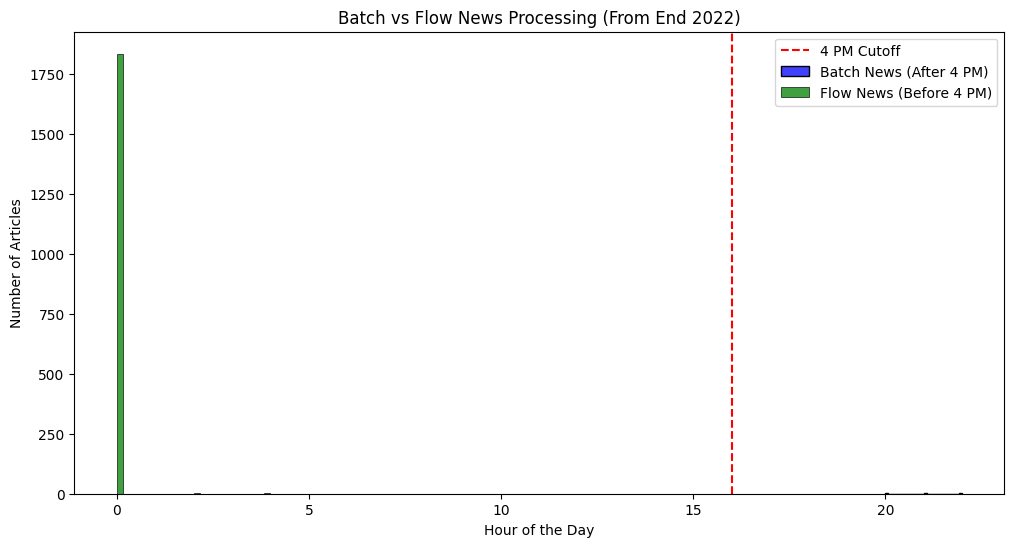

In [52]:
import seaborn as sns

# Filter data to include only from the end of 2022
start_date = '2022-12-01'
filtered_sentiment_data = sentiment_data[sentiment_data['Date'] >= start_date]

import matplotlib.pyplot as plt

# Ensure sentiment_data is in datetime format
filtered_sentiment_data['Date'] = pd.to_datetime(filtered_sentiment_data['Date'])

# Handling of after-hours news (4 PM cutoff)
plt.figure(figsize=(12, 6))
sns.histplot(filtered_sentiment_data['Date'].dt.hour, bins=24, kde=False)
plt.axvline(x=16, color='r', linestyle='--', label='4 PM Cutoff')
plt.title('Distribution of News Articles by Hour of the Day (From End 2022)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

# Define daily_sentiment
filtered_sentiment_data['Trading_Date'] = filtered_sentiment_data['Date'].apply(
	lambda x: (x + pd.Timedelta(days=1)).date() if x.hour >= 16 else x.date()
)
filtered_daily_sentiment = filtered_sentiment_data.groupby('Trading_Date')['Sentiment'].mean().reset_index()

# Effect of sentiment aggregation on trading days
plt.figure(figsize=(12, 6))
filtered_daily_sentiment['Trading_Date'] = pd.to_datetime(filtered_daily_sentiment['Trading_Date'])
sns.lineplot(data=filtered_daily_sentiment, x='Trading_Date', y='Sentiment')
plt.title('Daily Sentiment Aggregation Over Trading Days (From End 2022)')
plt.xlabel('Trading Date')
plt.ylabel('Average Sentiment')
plt.show()

# Examples of batch vs flow news processing
batch_news = filtered_sentiment_data[filtered_sentiment_data['Date'].dt.hour >= 16]
flow_news = filtered_sentiment_data[filtered_sentiment_data['Date'].dt.hour < 16]

plt.figure(figsize=(12, 6))
sns.histplot(batch_news['Date'].dt.hour, bins=24, kde=False, color='blue', label='Batch News (After 4 PM)')
sns.histplot(flow_news['Date'].dt.hour, bins=24, kde=False, color='green', label='Flow News (Before 4 PM)')
plt.axvline(x=16, color='r', linestyle='--', label='4 PM Cutoff')
plt.title('Batch vs Flow News Processing (From End 2022)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

I proceed as follos :

-News published after 4 PM is assigned to the next trading day using lambda, 

-Sentiment data is aggregated by trading day using the mean,

-left join with returns_data to retain only rows with both sentiment and return data

-Rows without corresponding sentiment data are dropped using

In [53]:

# 1. Process and check sentiment data and news published after 4PM are assigned to next trading day
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], dayfirst=True)
sentiment_data['Trading_Date'] = sentiment_data['Date'].apply(
    lambda x: (x + pd.Timedelta(days=1)).date() if x.hour >= 16 else x.date()
)

# 2. Process and check returns data
returns_data['Date'] = pd.to_datetime(returns_data['Date'], dayfirst=True).dt.date

# 3. Create daily sentiment and check its dates
daily_sentiment = sentiment_data.groupby('Trading_Date')['Sentiment'].mean().reset_index()

# 4. Merge with printed diagnostics
merged_data = pd.merge(
    returns_data,
    daily_sentiment,
    left_on='Date',
    right_on='Trading_Date',
    how='inner'
)

# 6. Check for any overlapping dates
returns_dates = set(returns_data['Date'])
sentiment_dates = set(daily_sentiment['Trading_Date'])
overlapping_dates = returns_dates.intersection(sentiment_dates)

/var/folders/00/1h1mgh1j2gb16vq65twfjnjh0000gn/T/ipykernel_16630/2408873225.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], dayfirst=True)


In [54]:
merged_data.head(5)

,Date,Close,Log_Return,Return_Label,Trading_Date,Sentiment
0,2020-03-10,71.334999,0.069546,1,2020-03-10,0.000000
1,2020-03-11,68.857498,-0.035348,-1,2020-03-11,0.142857
2,2020-03-12,62.057499,-0.103978,-1,2020-03-12,0.000000
3,2020-03-13,69.492500,0.113157,1,2020-03-13,0.375000
4,2020-03-16,60.552502,-0.137708,-1,2020-03-16,-0.500000


Descriptive Statistics for Returns:
count    216.000000
mean       0.000606
std        0.028150
min       -0.137708
25%       -0.013809
50%        0.000442
75%        0.015122
max        0.113157
Name: Log_Return, dtype: float64

Descriptive Statistics for Sentiment:
count    216.000000
mean       0.025799
std        0.332917
min       -1.000000
25%       -0.166667
50%        0.000000
75%        0.200000
max        1.000000
Name: Sentiment, dtype: float64

Correlation between Sentiment and Returns:
            Log_Return  Sentiment
Log_Return    1.000000   0.196119
Sentiment     0.196119   1.000000


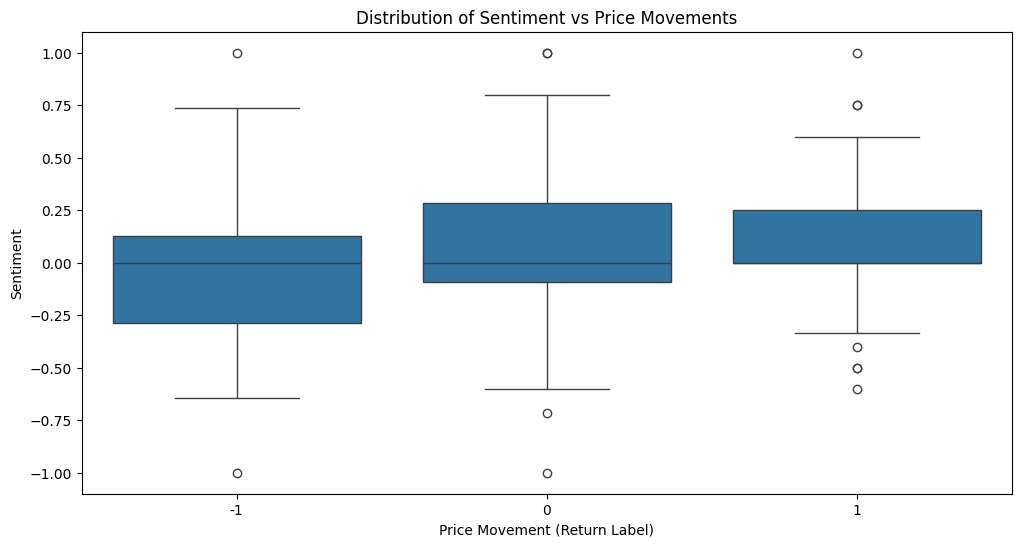

In [55]:
import seaborn as sns

import matplotlib.pyplot as plt

# Descriptive statistics for returns and sentiment
returns_stats = merged_data['Log_Return'].describe()
sentiment_stats = merged_data['Sentiment'].describe()

print("Descriptive Statistics for Returns:")
print(returns_stats)
print("\nDescriptive Statistics for Sentiment:")
print(sentiment_stats)

# Correlation analysis between sentiment and returns
correlation = merged_data[['Log_Return', 'Sentiment']].corr()
print("\nCorrelation between Sentiment and Returns:")
print(correlation)

# Distribution plots of sentiment vs price movements
plt.figure(figsize=(12, 6))
sns.boxplot(x='Return_Label', y='Sentiment', data=merged_data)
plt.title('Distribution of Sentiment vs Price Movements')
plt.xlabel('Price Movement (Return Label)')
plt.ylabel('Sentiment')
plt.show()

SyntaxError: invalid syntax (1590115108.py, line 3)

In [ ]:
merged_data